## Projekt - próba przewidzenia parametru $R_0$ przy użyciu uczenia maszynowego

#### Autorzy: Łukasz Eckert 132218, Damian Horna 132240

### 1. Wprowadzenie

Model SEIRD to tzw. compartmental model ([Wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)) wykorzystywany w celu modelowania
rozwoju epidemii. W modelu tym populacja jest podzielona na kilka grup, które opiszemy
poniżej. Skrót SEIRD rozwija się następująco:
* S - Susceptible - liczba osób podatnych na zachorowanie
* E - Exposed - liczba osób, u których choroba jest w stadium inkubacji
* I - Infectious - liczba osób, które rozprzestrzeniają chorobę
* R - Recovered - liczba osób, które wyzdrowiały
* D - Dead - liczba osób, które zmarły

![title](img/seird.png)

Obserwacje w tym modelu przepływają pomiędzy odpowiednimi bloczkami, proces ten można przedstawić za pomocą następujących równań różniczkowych:

![eq](img/equations.png)

Gdzie:
* N - całkowita populacja
* $S(t)$ - liczba osób podatnych (susceptible) do dnia t
* $E(t)$ - lliczba osób, u których choroba jest w stadium inkubacji do dnia t
* $I(t)$ - liczba osób zainfektowanych do dnia t
* $R(t)$ - liczba osób, które wyzdrowiały do dnia t
* $D(t)$ - liczba osób, które zmarły do dnia t
* $\beta$ - ozcekiwana liczba osób, którą zainfekowana osoba zaraża każdego dnia
* $D$ - liczba dni, przez które zainfekowana osoba może zarażać
* $\gamma$ - proporcja zainfekowanych, którzy zdrowieją każdego dnia ($\gamma = 1/D$)
* $R_0$ - łączna liczba osób, którą zainfekowana choroba zaraża ($R_0 = \beta / \gamma$)
* $\delta$ - długość okresu inkubacji
* $\alpha$ - współczynnik śmiertelności
* $\rho$ - tempo umieralności (=1/liczba dni od zainfekowania do śmierci)

## 2. Wygenerowanie sztucznego zbioru danych

### 2.1. Pojedyncza symulacja 

Na początku wygenerujemy proste dane z modelu SEIRD. Model, który opisuje założoną przez nas rzeczywistość mozna opisać poniższymi równaniami różniczkowymi:

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [74]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Ustawiamy parametry początkowe symulacji:

In [72]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [10]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

Przykładowy przebieg symulowanej epidemii

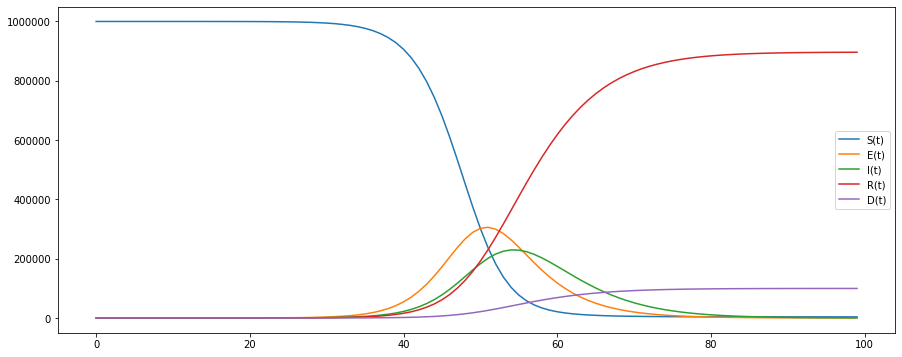

In [15]:
plt.figure(figsize=(15,6))
plt.plot(S, label='S(t)')
plt.plot(E, label='E(t)')
plt.plot(I, label='I(t)')
plt.plot(R, label='R(t)')
plt.plot(D, label='D(t)')
plt.legend()

Wygenerowane dane prezentują symulowany przebieg epidemii w okresie stu dni przy założonych warunkach początkowych i współczynnikach $\alpha, \beta, \gamma, \delta, \rho$

### 2.2. Wygenerowanie całego zbioru

Generujemy zbiór zakładając początkową populację 60 mln (rozmiar populacji Włoch) na przestrzeni 46 dni z różnymi parametrami symulacji (jak poniżej). Wybór liczby dni warunkujemy tym, iż później będziemy chcieli przetestować nasz model na danych zbieranych właśnie przez taki okres pochodzących właśnie z Włoch.

Na początku wybieramy zakres parametrów, które posłużą do wygenerowania zbioru danych, a następnie przeprowadzamy symulację.

In [16]:
from tqdm import tqdm
N=60e6 # populacja - ustawiamy ją w ten sposób, aby odpowiadała danym z Włoch
D_vals = np.arange(4,10,1) # liczba dni, podczas których zainfekowany zaraża
delta_vals = 1/np.arange(5,15,1) # 1/długość okresu inkubacji w dniach
R_0_vals = np.arange(2,5,0.25) # oczek. liczba osób, które zostaną zarażone przez jednego zainfekowanego
alpha_vals = np.arange(0.02, 0.2, 0.02) # wsp. śmiertelności
rho_vals = 1/np.arange(9,20,1) # tempo umieralności (1 / liczba dni do śmierci)
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

X = []
y = []

for D in tqdm(D_vals):
    for delta in delta_vals:
        for R_0 in R_0_vals:
            for alpha in alpha_vals:
                for rho in rho_vals:
                    gamma = 1.0/D
                    beta = R_0 * gamma
                    t = np.linspace(0, 46, 46) # Grid of time points (in days)
                    y0 = S0, E0, I0, R0, D0 # Initial conditions vector

                    # Integrate the SIR equations over the time grid, t.
                    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
                    #S, E, I, R, D = ret.T
                    X.append(ret.T)
                    y.append([beta, gamma, delta, alpha, rho])

100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


In [17]:
X = np.array(X)
y = np.array(y)

Zapisujemy wygenerowane dane - przydadzą się nam one wkrótce.

In [18]:
np.save('X.npy', X)
np.save('y.npy', y)

### 2.3. Podejrzenie przykładów uczących

In [35]:
def plot_train_example(ex):
    plt.figure(figsize=(15,6))
#     plt.plot(ex[0], label='S(t)')
    plt.plot(ex[1], label='E(t)')
    plt.plot(ex[2], label='I(t)')
    plt.plot(ex[3], label='R(t)')
    plt.plot(ex[4], label='D(t)')
    plt.legend()

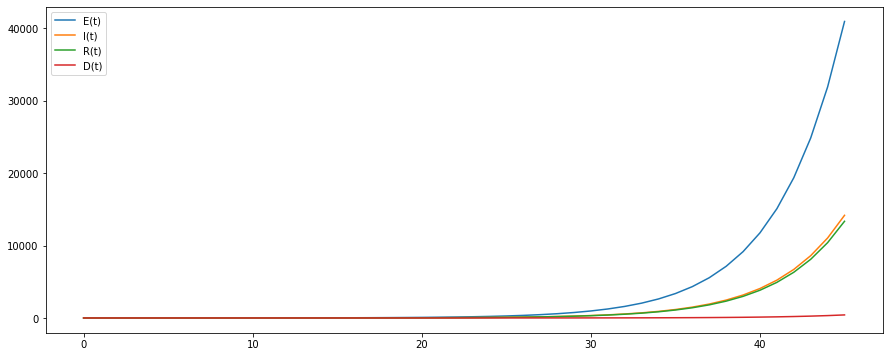

In [40]:
plot_train_example(X[2312])

### 3. Trening i selekcja modelu

Zaczniemy od modelu multi-output tree regression. Drzewa decyzyjne potrafią wyznaczyć nieliniową granicę decyzji, stąd też wydają nam się odpowiednią metodą z uwagi na nieliniowy charakter zależności w danych. Model ten natywnie wspiera przewidywanie kilku zmiennych naraz, z tego powodu również wydaje się atrakcyjny.

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [3]:
X = np.load('X.npy')

In [4]:
y = np.load('y.npy')

### Czy skalujemy dane? - Nie.

Ponieważ zamierzamy użyć regressora opartego o drzewo decyzyjne, skalowanie cech nie jest konieczne.

In [6]:
X =  X.reshape(X.shape[0],-1)

Do strojenia parametrów i walidacji modelu zastosujemy 10-krotną walidację krzyżową

In [5]:
kf = KFold(n_splits=10)

### Tuning głębokości drzewa, 10-fold cross validation

Następnie zajmiemy się strojeniem głębokości drzewa. W tym celu będziemy porównywać błędy popełniane przez drzewo na zbiorze treningowym i testowym dla różnych głębokości.

In [12]:
from tqdm import tqdm

In [13]:
depths_to_check = [2,4,5,7,9,11]

In [21]:
from collections import defaultdict
hypertuning_test = {}
hypertuning_train = {}

In [47]:
for depth in depths_to_check:
    mse_test = []
    mse_train = []
    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        regr = DecisionTreeRegressor(max_depth=depth)
        regr.fit(X_train, y_train)
        preds = regr.predict(X_test)
        mse_test.append((y_test - preds) ** 2)
        mse_train.append((y_train - regr.predict(X_train)) ** 2)

    mse_test = np.array(mse_test)
    mse_train = np.array(mse_train)
    
    #MSE calculation
    test_mse_v = np.mean(mse_test.reshape(10 * 7128, -1), axis=0)
    train_mse_v = np.mean(mse_train.reshape(10 *64152, -1), axis=0)
    hypertuning_test[depth] = test_mse_v
    hypertuning_train[depth] = train_mse_v

10it [00:27,  2.71s/it]
10it [00:49,  4.97s/it]
10it [00:59,  5.96s/it]
10it [01:17,  7.79s/it]
10it [01:33,  9.38s/it]
10it [01:47, 10.75s/it]


### Krzywe błędu MSE na zbiorze testowym i treningowym:

In [49]:
import seaborn as sns
import pandas as pd

In [50]:
data = pd.DataFrame(np.array(list(hypertuning_test.values())), [2,4,5,7,9,11], columns=["beta", "gamma", "delta", "alpha", "rho"])

Text(0.5, 1.0, 'MSE on test')

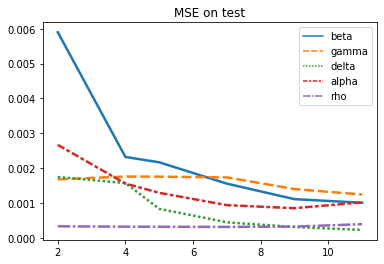

In [51]:
sns.lineplot(data=data, palette="tab10", linewidth=2.5)
plt.title("MSE on test")

In [53]:
data = pd.DataFrame(np.array(list(hypertuning_train.values())), [2,4,5,7,9,11], columns=["beta", "gamma", "delta", "alpha", "rho"])

Text(0.5, 1.0, 'MSE on train')

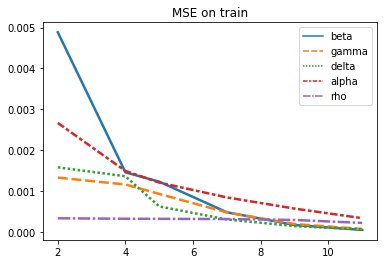

In [55]:
sns.lineplot(data=data, palette="tab10", linewidth=2.5)
plt.title("MSE on train")

Powyższe wykresy ukazują, iż sam błąd jest dość mały zarówno dla danych ze zbioru treningowego jak i testowego - nie mamy więc do czynienia z przeuczeniem, ponadto widać pewną saturację w miarę jak głębokość drzewa rośnie. Z tego powodu w naszych eksperymentach wykorzystywać będziemy drzewo o głębokości 11. Eksperyment sugeruje, że moglibyśmy przetestować również drzewa o większej głębokości, jednak na razie zostaniemy przy głebokości równej 11.

### 4. Przetestowanie modelu na rzeczywistych danych

Rzeczywiste dane zostały zaczerpnięte z pracy która ukazała się jakiś czas temu w Nature ([link](https://rdcu.be/b4x7F)). Są to dane zebrane we Włoszech od początku rozwoju epidemii. Autorzy artykułu udostępniają kod źródłowy rozwiązania w Matlab oraz dane, które pozwoliliśmy sobie przekleić wprost do notebooka.

Dane udostępnione przez autorów zawierają informacje o:
* Łącznej liczbie przypadków
* Liczbie śmierci
* Liczbie osób, które wyzdrowiały
* Liczbie osób obecnie zainfekowanych

Dane zebrane zostały w okresie od 20 lutego do 5 kwietnia 2020 (46 dni).

Ponadto autorzy dostarczają też takie dane, jak:
* Liczba osób wyizolowanych w domu
* Liczba osób obecnie hospitalizowanych
* Liczba osób przebywających na oddziale intensywnej terapii

Dane te jednakże zostały zebrane w innym terminie (23 luty - 5 kwietnia), z tego względu nie zostały one przez nas wykorzystane w żaden sposób.

Wykorzystujemy więc dane o R, D oraz I:

In [79]:
R = np.array([0, 0, 0, 1, 1, 1, 3, 45, 46, 50, 83, 149, 160, 276, 414, 523, 589, 622, 724, 1004, 1045, 1258, 1439, 1966, 2335, 2749, 2941, 4025, 4440, 5129, 6072, 7024, 7432, 8326, 9362, 10361, 10950, 12384, 13030, 14620, 15729, 16847, 18278, 19758, 20996, 21815])
D = np.array([0, 1, 2, 2, 5, 10, 12, 17, 21, 29, 34, 52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1266, 1441, 1809, 2158, 2503, 2978, 3405, 4032, 4825, 5476, 6077, 6820, 7503, 8165, 9134, 10023, 10779, 11591, 12428, 13155, 13915, 14681, 15362, 15887])
I = np.array([3, 19, 77, 129, 213, 311, 385, 588, 821, 1049, 1577, 1835, 2263, 2706, 3296, 3916, 5061, 6387, 7985, 8514, 10590, 12839, 14955, 17750, 20603, 23073, 26062, 28710, 33190, 37860, 42681, 46638, 50418, 54030, 57521, 62013, 66414, 70065, 73880, 75528, 77635, 80572, 83049, 85388, 88274, 91246])

Niestety nie jesteśmy w stanie przewidzieć, jakie sa liczby E oraz S wykorzystywane w naszym modelu. Moglibyśmy podejść do tego dwojako:
* Próbować estymować liczbę E na podstawie pozostałych danych
* Próbować nauczyć model tylko na R, D, I, wyrzucając ze zbioru treningowego E oraz S.

Zdecydowaliśmy się na drugą opcję.

### Spróbujemy więc nauczyć model na danych R, D, I.

In [58]:
X = np.load('X.npy')

In [59]:
y = np.load('y.npy')

In [60]:
X = X[:, [2,3,4], :]

In [61]:
X.shape

(71280, 3, 46)

In [62]:
X = X.reshape(X.shape[0],-1)

In [63]:
kf = KFold(n_splits=10)

In [64]:
scores_mse = []
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    regr = DecisionTreeRegressor(max_depth=10)
    regr.fit(X_train, y_train)
    preds = regr.predict(X_test)
    scores_mse.append((y_test - preds) ** 2)
    
scores_mse = np.array(scores_mse)

10it [01:11,  7.14s/it]


In [65]:
np.mean(scores_mse.reshape(10 * 7128, -1), axis=0)

array([3.80499258e-03, 1.31013707e-03, 6.48077769e-05, 1.15172189e-03,
       3.33451889e-04])

### Predykcja

In [68]:
X_test = np.array([I,R,D])

In [69]:
X_test = X_test.reshape(1, 3*46)

In [70]:
beta, gamma, delta, alpha, rho = regr.predict(X_test)[0]

In [75]:
t = np.linspace(0, 46, 46) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))

In [76]:
S_pred,E_pred,I_pred,R_pred,D_pred = ret.T

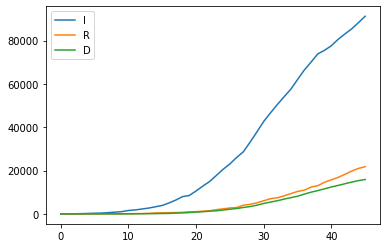

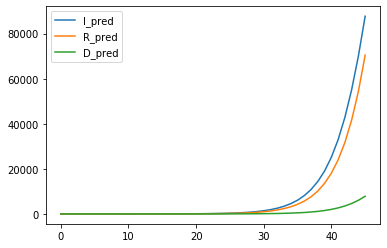

In [80]:
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.plot(D, label='D')
plt.legend()
plt.show()

plt.plot(I_pred, label='I_pred')
plt.plot(R_pred, label='R_pred')
plt.plot(D_pred, label='D_pred')
plt.legend()
plt.show()

### Oszacowane $R_0$: 

In [83]:
beta/gamma

5.0

### Uwaga: w naszym zbiorze uczącym nie było większych $R_0$ niż 5...

### Wnioski

Widzimy, że nasz model niestety rozmija się trochę z prawdą. Mimo, że skala wykresu jest odpowiednia, niestety przewidziany przez nas kształt krzywych odbiega od rzeczywistych danych. Dlaczego tak jest?

Jednym z powodów, dla których nasz model może się mylić jest rozbieżność między prawdziwymi danymi, a danymi z symulacji. Widzimy, że nasza zasymulowana epidemia bardzo długo nabiera rozpędu. Może to być spowodowane tym, iż COVID19 ma długi okres inkubacji, a dane rzeczywiste w zasadzie rozpoczynają się od momentu, gdy mamy już pierwszych zainfekowanych pacjentów.

Niestety mechanizm identyfikacji chorych nie jest doskonałych i z pewnością chore osoby zostały zidentyfikowane dopiero wtedy, gdy miały już dokuczliwe objawy. Model symulacyjny z kolei jest doskonały i nieodporny na wadliwe działanie identyfikacji chorych w rzeczywistym świecie.

Co możemy zrobić w takiej sytuacji? Zamiast uczyc na idealnych danych z symulacji, powinniśmy nieco zmodyfikować nasze przebiegi. Wydaje się, że moglibyśmy zacząć od przycinania ogonów (tych z lewej strony) naszych przebiegów z symulacji. Przyuczenie? Nie wiem czy poowinniśmy martwić się przeuczeniem, skoro naszym celem jest estymacja $R_0$ 

### Pomysły....

Po pierwsze epidemia w danych rozpoczyna się dośc szybko i gwałtownie, ta z symulacji długo się rozpędza

Po drugie warto sprawdzić jak ta epidemia testowa ma się w ogóle do danych które my wygenerowaliśmy w sensie dystrybucji

Po trzecie warto poprzycinać trochę wygenerowane dane tak aby najlepiej pasowały pod te rzeczywiste

Warto wspomnieć o potencjalnych różnicach między danymi rzeczywistymi i wygenerowanymi, gładka symulacja, zakładamy że R jest stałe a w rzeczywistości może to być jakaś funkcja i zmieniać się w czasie, mogą na to wpływać najróżniejsze czynniki

Dane z diamond princess